重点是构造一个估值因子，能够用来描述公司被高估/低估的情况

DCF模型可以用来描述这个因子，关键是找到未来现金流的预估
我就没找这个数据了，我假设围绕PE建模来替代

这个因子逻辑是这样：PE越低越容易被低估

以000300.XSHG里300家公司作为标的来展开回测

In [2]:
import sys
import os
sys.path.append('/Users/syesw/Desktop/JL-Code_Project/athena')

In [3]:
from dotenv import load_dotenv
load_dotenv()

rqdata_username = os.getenv('RQDATA_USERNAME')
rqdata_password = os.getenv('RQDATA_PASSWORD')

In [4]:
import rqdatac as rq
import pandas as pd
import numpy as np

In [5]:
from athena import RiceQuantDataHandler, Strategy, Backtest
from athena import sort_the_factor
from athena import run_weekly, run_monthly

In [6]:
# 设置时间范围
start_date = '2020-01-01'
end_date = '2024-10-01'
#asset_list = ['000651.XSHE', '600000.XSHG']
#asset_list = rq.index_components('000300.XSHG')
rqdata = RiceQuantDataHandler(start_date, end_date)
rqdata.auth(rqdata_username,rqdata_password)

asset_list = rqdata.get_index_list('000300.XSHG')

In [7]:
len(asset_list)

300

In [8]:
factor_data = rqdata.get_factors_from_ricequant(list=asset_list, factors=['pe_ratio_lyr'])

开始获取数据
数据获取完成
开始转换数据结构


In [9]:
backtest_data = rqdata.get_prices_from_ricequant(list=asset_list, fields=['open', 'high', 'low', 'close', 'volume'])

开始获取数据
数据获取完成
开始转换数据结构


In [10]:
print(factor_data.head())

print(backtest_data.head())

            002916.XSHE  000708.XSHE  300498.XSHE  300496.XSHE  601818.XSHG  \
           pe_ratio_lyr pe_ratio_lyr pe_ratio_lyr pe_ratio_lyr pe_ratio_lyr   
date                                                                          
2020-01-02    72.349506   132.797598    46.054829   113.622421     6.939525   
2020-01-03    71.093794   132.623017    46.444100   112.960971     6.892742   
2020-01-06    71.565903   131.226373    48.095147   119.844951     6.799175   
2020-01-07    72.378709   140.304561    51.337603   120.016438     6.861553   
2020-01-08    70.865040   133.146759    49.807541   119.452981     6.752392   

            600426.XSHG  600460.XSHG  002920.XSHE  601166.XSHG  600111.XSHG  \
           pe_ratio_lyr pe_ratio_lyr pe_ratio_lyr pe_ratio_lyr pe_ratio_lyr   
date                                                                          
2020-01-02    11.075486   122.152420    40.669630     6.925873    68.891142   
2020-01-03    11.053938   122.460303    41.356930  

In [11]:
class SortedFactorInvestStrategy(Strategy):
    def init(self):
        print("回测准备:")
        self.first_time = True

    @run_monthly
    def next(self, i, record):
        print("----------------------")
        date = self.data.index[i]
        print(str(date) + ': ')

        current_long_positions, current_short_positions = self.broker.current_position_status()
        print("我目前持仓情况:")
        print("多头仓位:", current_long_positions)
        print("空头仓位:", current_short_positions)

        day_factors = factor_data.loc[date] # 当天的因子数据
        sorted_factor_series = sort_the_factor(day_factors, 'pe_ratio_lyr') # 从高到低排因子

        print('因子排名前5的股票:')
        print(sorted_factor_series[:5].index.tolist())
        short_stocks = sorted_factor_series[:5].index.tolist()
        #short_stocks = []
        print('因子排名后5的股票:')
        print(sorted_factor_series[-5:].index.tolist())
        long_stocks = sorted_factor_series[-5:].index.tolist()

        # 先换仓
        long_closed = short_closed = 0
        for stock in current_long_positions:
            # 对于我目前的所有多头仓位,如果不在新的list里，则平仓
            if stock not in long_stocks:
                print("关多仓:", stock)
                self.close(symbol=stock, price=record[(stock,'Close')])
                long_closed += 1
        for stock in current_short_positions:
            if stock not in short_stocks:
                print("关空仓:", stock)
                self.close(symbol=stock, price=record[(stock,'Close')])
                short_closed += 1

        total_closed = long_closed + short_closed
        if self.first_time == True:
            re_invest_size = 1 / 10 # 10只股票
        else: re_invest_size = 1 / total_closed # 关了多少，就重新开多少

        # 买进新的股票
        # 这里的换仓逻辑是，不去干涉已经开仓的股票(不加仓)
        # 对于新开仓的股票，按可分配资金的数量(1/total_closed)来开仓
        # 这样做实现了滚仓的效果
        for stock in long_stocks:
            if long_closed == 0 and self.first_time == False:
                break
            if stock not in current_long_positions:
                print("新开多仓:", stock)
                self.open(symbol=stock, size=re_invest_size, price=record[(stock,'Open')], short=False)
                long_closed -= 1
        for stock in short_stocks:
            if short_closed == 0 and self.first_time == False:
                break
            if stock not in current_short_positions:
                print("新开空仓:", stock)
                self.open(symbol=stock, size=re_invest_size, price=record[(stock,'Open')], short=True)
                short_closed -= 1
        
        self.first_time == False

        print("----------------------")


In [12]:
backtest = Backtest(SortedFactorInvestStrategy, backtest_data, commission=.001, cash=100_0000)

In [13]:
res = backtest.run()

回测准备:
----------------------
2020-01-02 00:00:00: 
我目前持仓情况:
多头仓位: []
空头仓位: []
因子排名前5的股票:
['002459.XSHE', '600745.XSHG', '300223.XSHE', '601808.XSHG', '603501.XSHG']
因子排名后5的股票:
['000792.XSHE', '000807.XSHE', '000063.XSHE', '002252.XSHE', '600584.XSHG']
新开多仓: 000792.XSHE
新开多仓: 000807.XSHE
新开多仓: 000063.XSHE
新开多仓: 002252.XSHE
新开多仓: 600584.XSHG
新开空仓: 002459.XSHE
新开空仓: 600745.XSHG
新开空仓: 300223.XSHE
新开空仓: 601808.XSHG
新开空仓: 603501.XSHG
----------------------
----------------------
2020-02-03 00:00:00: 
我目前持仓情况:
多头仓位: ['000792.XSHE', '000807.XSHE', '000063.XSHE', '002252.XSHE', '600584.XSHG']
空头仓位: ['002459.XSHE', '600745.XSHG', '300223.XSHE', '601808.XSHG', '603501.XSHG']
因子排名前5的股票:
['002459.XSHE', '600745.XSHG', '300223.XSHE', '603501.XSHG', '601808.XSHG']
因子排名后5的股票:
['000792.XSHE', '000807.XSHE', '000063.XSHE', '002252.XSHE', '600584.XSHG']
----------------------
----------------------
2020-03-04 00:00:00: 
我目前持仓情况:
多头仓位: ['000792.XSHE', '000807.XSHE', '000063.XSHE', '002252.XSHE', '600584.X

In [14]:
len(res.trades)

75

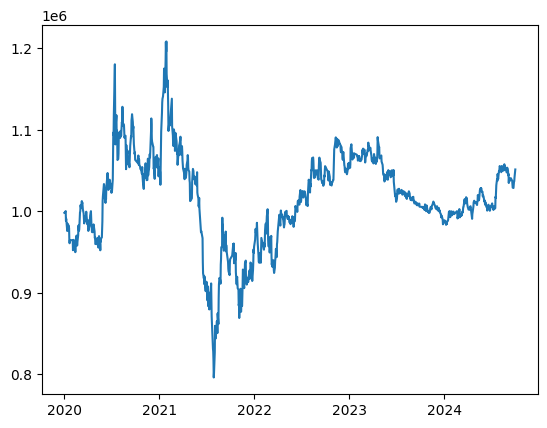

In [15]:
import matplotlib.pyplot as plt
plt.plot(res.returns)

In [16]:
res.returns

2020-01-02    9.980192e+05
2020-01-03    9.981370e+05
2020-01-06    9.995165e+05
2020-01-07    1.000145e+06
2020-01-08    9.883266e+05
                  ...     
2024-09-24    1.032978e+06
2024-09-25    1.036361e+06
2024-09-26    1.036753e+06
2024-09-27    1.041529e+06
2024-09-30    1.051265e+06
Length: 1151, dtype: float64

In [17]:
trades = pd.DataFrame(res.trades)
trades

,symbol,short,open_date,close_date,open_price,close_price,position_size,profit_loss,change_pct,trade_commission,cumulative_return
0,000807.XSHE,False,2020-01-02,2020-04-03,4.8820,3.6072,18416.650944,-23477.546624,-26.112249,156.342633,9.763661e+05
1,000063.XSHE,False,2020-01-02,2020-04-03,33.5555,38.5521,2411.499782,12049.299808,14.890554,173.887462,9.882415e+05
2,002459.XSHE,True,2020-01-02,2020-04-03,5.5806,6.4001,10570.549760,-8662.565528,-14.684801,126.642586,9.794523e+05
3,601808.XSHG,True,2020-01-02,2020-04-03,18.1656,12.1324,2367.316097,14282.491473,33.212225,71.724943,9.936631e+05
4,002252.XSHE,False,2020-01-02,2020-05-06,7.2649,8.3893,10024.525159,11271.576089,15.477157,156.925922,1.004778e+06
...,...,...,...,...,...,...,...,...,...,...,...
70,000100.XSHE,True,2023-09-08,2024-05-08,3.9850,4.5543,12925.444312,-7358.455447,-14.286073,110.374247,1.012830e+06
71,688041.XSHG,True,2024-04-08,2024-05-08,74.3885,76.2458,792.431883,-1471.783736,-2.496757,119.367422,1.011239e+06
72,002230.XSHE,True,2024-04-08,2024-05-08,47.5551,44.2331,1115.611936,3706.062853,6.985581,102.400012,1.014842e+06
73,601698.XSHG,True,2024-05-08,2024-07-08,16.2817,13.2800,2664.800440,7998.931481,18.436036,78.776031,1.022763e+06


In [18]:
open_pos = pd.DataFrame(res.open_positions)
open_pos

,symbol,open_date,last_date,open_price,last_price,position_size,profit_loss,change_pct,current_value,is_short
0,688256.XSHG,2023-04-10,2024-09-30,225.5000,289.16,310.525918,19768.079970,28.230599,89791.674584,False
1,601989.XSHG,2023-05-10,2024-09-30,4.8315,5.50,17938.833083,11992.109916,13.836283,98663.581954,False
2,301269.XSHE,2023-05-10,2024-09-30,113.6284,93.01,500.448416,10318.445623,18.145464,67183.598427,True
3,601111.XSHG,2024-04-08,2024-09-30,7.3500,7.88,8911.234938,4722.954517,7.210884,70220.531308,False
4,601360.XSHG,2024-05-08,2024-09-30,9.0679,8.81,8102.987528,-2089.760484,-2.844098,71387.320123,False
5,600460.XSHG,2024-05-08,2024-09-30,19.8000,22.62,3339.867300,9418.425787,14.242424,75547.798333,False
6,603986.XSHG,2024-05-08,2024-09-30,84.0000,88.37,708.528992,-3096.271693,-5.202381,56420.163598,True
7,603501.XSHG,2024-05-08,2024-09-30,104.1942,107.20,514.086118,-1545.240053,-2.884805,52019.551710,True
8,688126.XSHG,2024-05-08,2024-09-30,13.5940,18.98,3546.293408,-19100.336295,-39.620421,29107.976291,True
9,601698.XSHG,2024-08-07,2024-09-30,17.1900,17.28,2564.030312,-230.762728,-0.523560,43844.918339,True
